In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 300
pd.options.display.max_rows = 300

In [4]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

# to_datetime

train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

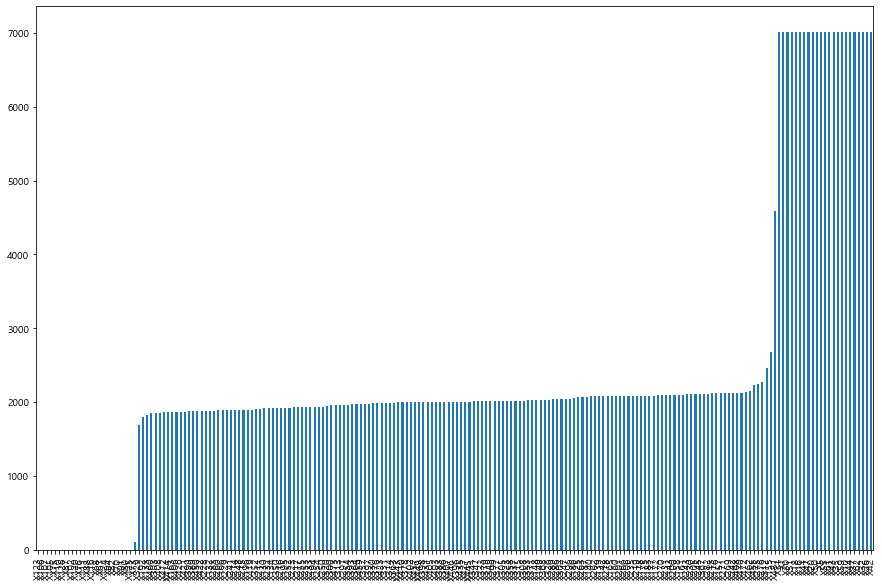

In [5]:
# 결측치 갯수 시각화
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

In [6]:
## 결측치가 없는 세대
test.loc[:,test.isnull().sum()==0].columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107'],
      dtype='object')

In [7]:
# sample 데이터
test_sample = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

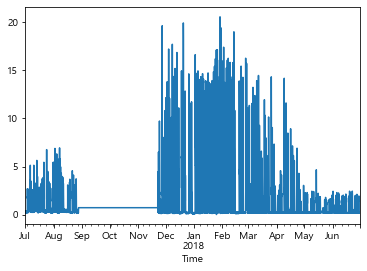

In [8]:
test_sample['X125'].plot()

(4362, 7)
     t-6    t-5    t-4     t-3     t-2     t-1     t-0
0  0.261  0.205  0.212   0.266   0.228   0.301   0.279
1  0.205  0.212  0.266   0.228   0.301   0.279   0.205
2  0.212  0.266  0.228   0.301   0.279   0.205  10.226
3  0.266  0.228  0.301   0.279   0.205  10.226  12.156
4  0.228  0.301  0.279   0.205  10.226  12.156   5.136
5  0.301  0.279  0.205  10.226  12.156   5.136   2.997
        t-6    t-5    t-4    t-3    t-2    t-1    t-0
4356  1.361  1.379  2.041  1.387  1.377  1.308  1.057
4357  1.379  2.041  1.387  1.377  1.308  1.057  0.878
4358  2.041  1.387  1.377  1.308  1.057  0.878  0.605
4359  1.387  1.377  1.308  1.057  0.878  0.605  0.231
4360  1.377  1.308  1.057  0.878  0.605  0.231  0.302
4361  1.308  1.057  0.878  0.605  0.231  0.302  0.215
(100, 7)
(4261, 7)


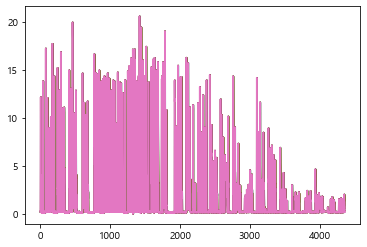

In [9]:
# # 이전 12 개월치 승객 수(x) 를 이용해서 
# # 다음달 승객 수(y) 를 추측할 수 있도록 데이터를 변형해 줍니다.
# len_data = len(test_sample['X125']['2017-12':'2018-05'])
# columns = []
# column_names = []
# months = 6
# for i in range(0, months + 1):
#     shift = (months - i)
#     column = test_sample['X125']['2017-12':'2018-05'][i:len_data - shift].reset_index(drop=True)
#     columns.append(column)
#     column_names.append("t-%s" % shift)
# xy = pd.concat(columns, keys=column_names, axis=1)
    
# print(xy.shape)
# plt.plot(xy)
# print(xy.head(6))
# print(xy.tail(6))

# # 훈련과 평가를 위해 데이터 셋을 대략 7:3 정도로 훈련/테스트용으로 나누어 줍니다.
# train_data = xy[:][0:100].reset_index(drop=True)
# test_data = xy[:][100:-1].reset_index(drop=True)
# print(train_data.shape)
# print(test_data.shape)

In [10]:
# from sklearn import preprocessing
# # train_sdata = train_data.values
# # test_sdata = test_data.values

# # 빠른 훈련을 위해 min max 값을 이용하여 0~1 값을 가지도록 normalization 합니다.
# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# train_sdata = scaler.fit_transform(train_data).astype('float32')
# test_sdata = scaler.fit_transform(test_data).astype('float32')
# print(type(train_sdata), train_sdata.shape)
# print(type(test_sdata), test_sdata.shape)

# # 훈련시 사용할 다음 랜덤 batch를 생성함수를 미리 만들어 줍니다.
# def next_batch(sdata, size):
#     data = np.array(sdata, copy=True)
#     x_dim = data.shape[1] - 1
#     if (size <= 0):
#         return data[:, :x_dim].reshape(-1, x_dim, 1), data[:, -1].reshape(-1, 1)
#     np.random.shuffle(data)
#     sample = data[:size]
#     #print(sample.shape)
#     #print(sample)
#     return sample[:, :x_dim].reshape(-1, x_dim, 1), sample[:, -1].reshape(-1, 1)

# xs, ys = next_batch(train_sdata, 0)
# print(xs[:2])
# print(ys[:2])
# print(xs.shape, ys.shape)
# xs, ys = next_batch(test_sdata, 0)
# print(xs.shape, ys.shape)

<class 'numpy.ndarray'> (100, 7)
<class 'numpy.ndarray'> (4261, 7)
[[[0.00772608]
  [0.00444835]
  [0.00485806]
  [0.00801873]
  [0.00579456]
  [0.01006731]]

 [[0.00444835]
  [0.00485806]
  [0.00801873]
  [0.00579456]
  [0.01006731]
  [0.00877963]]]
[[0.00877963]
 [0.00444835]]
(100, 6, 1) (100, 1)
(4261, 6, 1) (4261, 1)


In [11]:
# import tensorflow as tf
# from tensorflow.python.framework import dtypes
# from tensorflow.contrib import rnn

# # Tensorflow를 이용해 LSTM 모델을 생성합니다.
# # 입력으로 1차원 input 12개를 받고 12개의 output를 내는 12층을 가진 LSTM 입니다.
# lstm_size = 1 
# time_step_size = 6
# stack_size = 6
# input_dim = 1

# # input
# feed_xs = tf.placeholder(tf.float32, shape=[None, time_step_size, input_dim])
# print(feed_xs)
# feed_ys = tf.placeholder(tf.float32, shape=[None, lstm_size])
# print(feed_ys)

# # LSTM layer
# lstm_cell = rnn.BasicLSTMCell(lstm_size, state_is_tuple=True)
# stacked_lstm = rnn.MultiRNNCell([lstm_cell] * stack_size, state_is_tuple=True)
# outputs, states = tf.nn.dynamic_rnn(stacked_lstm, feed_xs, dtype=dtypes.float32)
# print(outputs)

# # cost
# # 최종 예측 y값은 1차원이므로 LSTM output에서 마지막 차원 값을 cost를 계산시 사용합니다.
# pred_ys = outputs[:, -1]
# print(pred_ys)

# learning_rate = 0.0001
# cost = tf.reduce_sum(tf.square(feed_ys - pred_ys))
# optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Tensor("Placeholder:0", shape=(?, 6, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Tensor("rnn/transpose_1:0", shape=(?, 6, 1), dtype=float32)
Tensor("strided_slice:0", shape=(?, 1), dtype=float32)


In [12]:
# def mkdir(dir_path):
#     if tf.gfile.Exists(dir_path):
#         tf.gfile.DeleteRecursively(dir_path)
#     tf.gfile.MakeDirs(dir_path)

# def train_epoch(epoch, steps, batch_size):
#     init = tf.global_variables_initializer()
#     sess.run(init)

#     saver = tf.train.Saver()
#     path_format = "../models/tf-rnn-iap-%03d/"
#     prev_model_path = path_format % (epoch - 1)
#     prev_model_file = "%s%s" % (prev_model_path, "model")
#     if tf.gfile.Exists(prev_model_path):
#         saver.restore(sess, prev_model_file)

#     for step in range(steps):
#         train_xs, train_ys = next_batch(train_sdata, batch_size)
#         sess.run(optimizer, feed_dict={feed_xs: train_xs, feed_ys: train_ys})

#     train_xs, train_ys = next_batch(train_sdata, 0)
#     train_cost, train_pred_ys = sess.run([cost, pred_ys], feed_dict={feed_xs: train_xs, feed_ys: train_ys})
#     print("epoch: %s, train_cost: %s" % (epoch, train_cost))

#     test_xs, test_ys = next_batch(test_sdata, 0)
#     test_cost, test_pred_ys = sess.run([cost, pred_ys], feed_dict={feed_xs: test_xs, feed_ys: test_ys})
#     print("epoch: %s, test_cost: %s" % (epoch, test_cost))

#     curr_model_path = path_format % epoch
#     curr_model_file = "%s%s" % (curr_model_path, "model")
#     print("save model: %s" % curr_model_file)
#     mkdir(curr_model_path)
#     saver.save(sess, curr_model_file)

# # 배치 사이즈는 1개이고 각 epoch 마다 10만 스텝의 최적화 후 모델을 저장합니다.
# batch_size = 1
# with tf.Session() as sess:
#     for epoch in range(0, 5):    
#         train_epoch(epoch, 100000, batch_size)

epoch: 0, train_cost: 4.6087837
epoch: 0, test_cost: 92.30235
save model: ../models/tf-rnn-iap-000/model
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/tf-rnn-iap-000/model
epoch: 1, train_cost: 4.6096144
epoch: 1, test_cost: 93.264656
save model: ../models/tf-rnn-iap-001/model
INFO:tensorflow:Restoring parameters from ../models/tf-rnn-iap-001/model
epoch: 2, train_cost: 4.6088676
epoch: 2, test_cost: 92.86897
save model: ../models/tf-rnn-iap-002/model
INFO:tensorflow:Restoring parameters from ../models/tf-rnn-iap-002/model
epoch: 3, train_cost: 4.610835
epoch: 3, test_cost: 91.60585
save model: ../models/tf-rnn-iap-003/model
INFO:tensorflow:Restoring parameters from ../models/tf-rnn-iap-003/model
epoch: 4, train_cost: 4.6086736
epoch: 4, test_cost: 92.622856
save model: ../models/tf-rnn-iap-004/model


In [13]:
# # 훈련된 모델 중 하나를 불러옵니다.
# with tf.Session() as sess:
#     epoch = 4
#     init = tf.global_variables_initializer()
#     sess.run(init)

#     saver = tf.train.Saver()

#     path_format = "../models/tf-rnn-iap-%03d/"
#     curr_model_path = path_format % epoch
#     curr_model_file = "%s%s" % (curr_model_path, "model")
#     saver.restore(sess, curr_model_file)

#     train_xs, train_ys = next_batch(train_sdata, 0)
#     train_cost, train_pred_ys = sess.run([cost, pred_ys], feed_dict={feed_xs: train_xs, feed_ys: train_ys})
#     print("epoch: %s, train_cost: %s" % (epoch, train_cost))

#     test_xs, test_ys = next_batch(test_sdata, 0)
#     test_cost, test_pred_ys = sess.run([cost, pred_ys], feed_dict={feed_xs: test_xs, feed_ys: test_ys})
#     print("epoch: %s, test_cost: %s" % (epoch, test_cost))

INFO:tensorflow:Restoring parameters from ../models/tf-rnn-iap-004/model
epoch: 4, train_cost: 4.6086736
epoch: 4, test_cost: 92.622856


(100, 1)


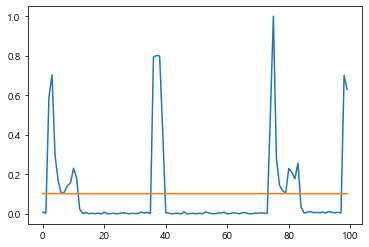

In [16]:
# # 훈련 데이터 값과 예측치를 비교해 봅니다.
# np_py = np.array(train_pred_ys)
# print(np_py.shape)
# plt.plot(train_ys)
# plt.plot(np_py.reshape(-1, 1))

In [12]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

from keras.layers import TimeDistributed

def make_model():
    model = Sequential()
    model.add(SimpleRNN(10, return_sequences=True, input_shape=(3,1)))
    model.add(TimeDistributed(Dense(1,activation='linear')))
    model.compile(loss='mse', optimizer='sgd')
    model.summary()
    return model2

In [ ]:
x_train, y_train = 
model = make_model()

In [11]:
history = model.fit(X_train,Y_train, epochs=100, verbose=0)

NameError: name 'model' is not defined

In [ ]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.show()

In [ ]:
plt.subplot(211)
plt.plot([1,2,3], X_train[1].flatten(), 'bo-', label='input sequence')
plt.plot([4,5,6], Y_train[1].flatten(), 'ro-', label='target sequence')
plt.plot([4,5,6], model.predict(X_train[1:2,:,:]).flatten(),'gs-',label='output sequence')
plt.xlim(-0.5,7.5)
plt.ylim(-1.1,1.1)
plt.legend()
plt.title('sample sequence')

plt.subplot(212)
plt.plot([2,3,4], X_train[1].flatten(), 'bo-', label='input sequence')
plt.plot([5,6,7], Y_train[1].flatten(), 'ro-', label='target sequence')
plt.plot([5,6,7], model.predict(X_train[2:3,:,:]).flatten(),'gs-',label='output sequence')
plt.xlim(-0.5,7.5)
plt.ylim(-1.1,1.1)
plt.legend()
plt.title('sample sequence')
plt.tight_layout()
plt.show()